In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shate - columns like name, population, elevation and the like. 

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [2]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Serveiry, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

In [4]:
coord_ref_sys = "EPSG:25829" 
# Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation

### Filter out to our target area: Portugal

In [5]:
# GeoPandas looks in the same directory for data files by default (.dbf, .shx, etc.)
fire_data = gpd.read_file(FIRE_DATA_PATH)
fire_data = fire_data.to_crs(coord_ref_sys) # reproject to our fixed CRS
fire_data = fire_data[fire_data["COUNTRY"] == "PT"]
fire_date = fire_data.iloc[:100]
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4..."
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,0,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4..."
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,0,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4..."
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,0,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45..."


In [6]:
world = gpd.read_file(COUNTRY_BOUNDARY_PATH)
portugal = world[world["NAME"] == "Portugal"]

# https://epsg.io/25829
# Reprojection of Portugal to our fixed CRS (specified above)
portugal_proj = portugal.to_crs(coord_ref_sys) # degrees -> met
mainland = portugal_proj.iloc[portugal_proj.geometry.area.argmax()]
mainland_polygon = mainland.geometry

# Extract boudning box around Portugal 
minx, miny, maxx, maxy = mainland_polygon.bounds
print(minx, miny, maxx, maxy)

454235.1439060115 4077542.239783567 718319.3451133408 4681179.434351782


In [7]:
grid_size = 2000 # meters - discretization size of what one node is in our graph
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

In [8]:
# create grid
grid_squares = []
for x in x_coords:
    for y in y_coords:
        # this makes a full rectangle grid
        cell = box(x, y, x + grid_size, y + grid_size)
        # only add cells that are inside mainland portugal (leave out the sea)
        if mainland_polygon.contains(cell):
            grid_squares.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_squares}, crs=coord_ref_sys)
grid.head()
# each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

,geometry
0,"POLYGON ((458235.144 4285542.24, 458235.144 42..."
1,"POLYGON ((458235.144 4287542.24, 458235.144 42..."
2,"POLYGON ((458235.144 4289542.24, 458235.144 42..."
3,"POLYGON ((458235.144 4291542.24, 458235.144 42..."
4,"POLYGON ((458235.144 4293542.24, 458235.144 42..."


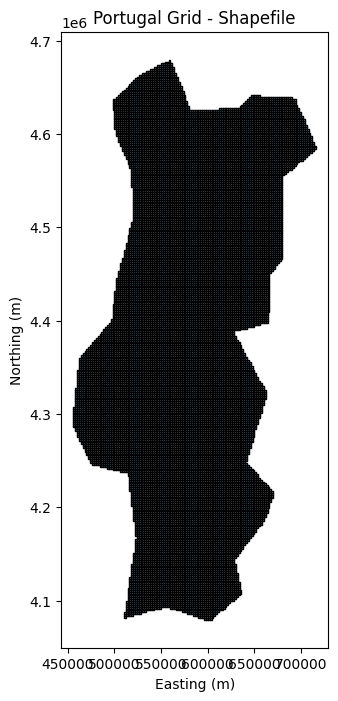

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
grid.plot(ax=ax, edgecolor='black', facecolor='lightblue')
ax.set_title("Portugal Grid - Shapefile")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

In [10]:
grid.to_file("output/portugal_grid.shp")
grid.to_file("output/portugal_grid.gpkg", layer="grid", driver="GPKG")

In [11]:
# add columns for coordinates of grid squares' centers
grid_gdf = grid.copy()
#rename geometry to geometry grid
# grid_gdf = grid_gdf.rename(columns={'geometry': 'geometry_grid'})
grid_gdf["centroid_grid"] = grid.geometry.centroid
grid_gdf["centroid_x_grid"] = grid.geometry.centroid.x
grid_gdf["centroid_y_grid"] = grid.geometry.centroid.y
grid_gdf.head()

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid
0,"POLYGON ((458235.144 4285542.24, 458235.144 42...",POINT (457235.144 4286542.24),457235.143906,4.286542e+06
1,"POLYGON ((458235.144 4287542.24, 458235.144 42...",POINT (457235.144 4288542.24),457235.143906,4.288542e+06
2,"POLYGON ((458235.144 4289542.24, 458235.144 42...",POINT (457235.144 4290542.24),457235.143906,4.290542e+06
3,"POLYGON ((458235.144 4291542.24, 458235.144 42...",POINT (457235.144 4292542.24),457235.143906,4.292542e+06
4,"POLYGON ((458235.144 4293542.24, 458235.144 42...",POINT (457235.144 4294542.24),457235.143906,4.294542e+06


In [11]:
grid_gdf.describe()

,centroid_x_grid,centroid_y_grid
count,22841.000000,2.284100e+04
mean,580519.500983,4.384702e+06
std,52755.422402,1.565409e+05
min,457235.143906,4.080542e+06
25%,539235.143906,4.260542e+06
50%,579235.143906,4.382542e+06
75%,621235.143906,4.520542e+06
max,715235.143906,4.678542e+06


#### Overlay with Fire Data

Assumption - if a centroid overlaps with a fire point - this is our fire node. We want to make this into a series, per date, for each fire.

In [12]:
# fires_with_centroids["centroid_x"] = fire_data["GEOMETRY"]
fire_data["centroid_x_fire"] = fire_data['geometry'].apply(lambda x: x.centroid.x)
fire_data["centroid_y_fire"] = fire_data['geometry'].apply(lambda y: y.centroid.y)
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4...",569537.929816,4.526903e+06
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4...",578340.742797,4.584768e+06
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4...",526512.771879,4.401550e+06
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4...",606905.317296,4.457301e+06
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45...",549250.037391,4.572389e+06


In [20]:
fire_data = fire_data.to_crs(grid_gdf.crs)
fire_data['geometry'] = fire_data.geometry.centroid
joined = gpd.sjoin(fire_data, grid_gdf, how="right", predicate="within")
fire_centroids = fire_data.copy()
fire_centroids['geometry'] = fire_centroids.geometry.centroid

# Perform spatial join: fire centroid within grid polygons - Faster than iterating over each centroid - https://www.youtube.com/watch?v=y85IKthrV-s
# We join POINT with POLYGON

joined = gpd.sjoin(fire_centroids, grid_gdf, how="left", predicate="within")

joined['has_fire'] = ~joined['index_right'].isna()
joined

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire,index_right,centroid_grid,centroid_x_grid,centroid_y_grid,has_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,9.843358251326316,FireSeason,POINT (569537.93 4526902.766),569537.929816,4.526903e+06,10098.0,POINT (569235.144 4526542.24),569235.143906,4.526542e+06,True
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,0,FireSeason,POINT (578340.743 4584767.984),578340.742797,4.584768e+06,11523.0,POINT (579235.144 4584542.24),579235.143906,4.584542e+06,True
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,0,FireSeason,POINT (526512.772 4401549.956),526512.771879,4.401550e+06,3949.0,POINT (527235.144 4402542.24),527235.143906,4.402542e+06,True
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,38.26787498738594,FireSeason,POINT (606905.317 4457301.419),606905.317296,4.457301e+06,15265.0,POINT (607235.144 4456542.24),607235.143906,4.456542e+06,True
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,0,FireSeason,POINT (549250.037 4572389.254),549250.037391,4.572389e+06,7215.0,POINT (549235.144 4572542.24),549235.143906,4.572542e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83514,279514,2025-08-16 13:59:00,2025-08-28 14:45:54.47225,PT,Viseu Dão Lafões,"Mamouros, Alva e Ribolhos",2,0,66.66666666444443,0,...,0,FireSeason,POINT (586698.528 4522302.35),586698.528404,4.522302e+06,12576.0,POINT (587235.144 4522542.24),587235.143906,4.522542e+06,True
83515,279521,2025-08-15 13:29:00,2025-08-28 15:10:56.130884,PT,Tâmega e Sousa,Rans,9,0,0,0,...,0,FireSeason,POINT (557743.731 4558139.845),557743.730957,4.558140e+06,8372.0,POINT (557235.144 4558542.24),557235.143906,4.558542e+06,True
83852,281625,2025-09-16 14:18:00,2025-09-22 08:50:25.476203,PT,Alto Tâmega,Santo André,689,0,0,0,...,0,7DAYS,POINT (607507.447 4637097.844),607507.447198,4.637098e+06,NaN,None,NaN,NaN,False
83859,281622,2025-09-20 01:17:00,2025-09-22 08:45:09.029596,PT,Douro,"Cepões, Meijinhos e Melcões",51,0,0,0,...,25.08291595482275,7DAYS,POINT (599507.661 4545624.503),599507.660547,4.545625e+06,14221.0,POINT (599235.144 4546542.24),599235.143906,4.546542e+06,True


In [15]:
import numpy as np
from tqdm import tqdm
joined["geometry_centroid"] = joined.geometry.centroid
coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]

# Initialize with zeros  
# Note: this method does not handle an edge case where multiple fires occured at the same place,
joined["fire_intensity"] = 0

for filename in tqdm(os.listdir(WILDFIRE_SEVERITY_DIR)):
    if filename.endswith(".tiff"):
        filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
        with rasterio.open(filepath) as src:
            print(f"Processing {filename}")

            # Ensure CRS match
            if joined.crs != src.crs:
                joined = joined.to_crs(src.crs)
                joined["geometry_centroid"] = joined.geometry.centroid
                coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]

            # Get raster values
            values = np.array([val[0] for val in src.sample(coords)])
            print(values)

            # Take the maximum intensity per fire across rasters
            joined["fire_intensity"] = np.maximum(joined["fire_intensity"], values)


/tmp/ipykernel_18089/502918896.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  joined["geometry_centroid"] = joined.geometry.centroid
  0%|          | 0/16 [00:00<?, ?it/s]

Processing severity_2018.tiff


  6%|▋         | 1/16 [00:06<01:37,  6.49s/it]


KeyboardInterrupt: 

In [16]:
joined = joined.dropna(subset=["centroid_grid"])

In [17]:
from datetime import datetime
import pandas as pd


joined["DAY"] = pd.to_datetime(joined["FIREDATE"], format='mixed').dt.date

In [19]:
import fiona
import geopandas as gpd
import os
import pandas as pd 
from shapely.strtree import STRtree
from shapely.geometry import Point

# Path to your GDB
gdb_path = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

# List of layer indices we need
layer_indices = [0, 1, 6, 8, 9]

# Read and concatenate all water layers
water_gdfs = []
for idx in layer_indices:
    layer_name = fiona.listlayers(gdb_path)[idx]
    gdf_layer = gpd.read_file(gdb_path, layer=layer_name)
    water_gdfs.append(gdf_layer)

# Combine all layers into a single GeoDataFrame
water_gdf = gpd.GeoDataFrame(pd.concat(water_gdfs, ignore_index=True))
print("Combined water bodies:", water_gdf.shape)

joined = joined.set_geometry('centroid_grid')

# Ensure the CRS matches the water layer
joined = joined.to_crs(water_gdf.crs)

water_gdf = water_gdf[water_gdf.geometry.notnull()]
water_geoms = water_gdf.geometry.values
water_tree = STRtree(water_gdf.geometry.values)

def nearest_water(point):
    if point is None or point.is_empty:
        return None
    # nearest() now returns index
    nearest_idx = water_tree.nearest(point)
    nearest_geom = water_geoms[nearest_idx]  # get the actual geometry
    return point.distance(nearest_geom)

joined['dist_to_water'] = joined.geometry.apply(nearest_water)
joined.head()


Combined water bodies: (41321, 52)


,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,centroid_y_fire,index_right,centroid_grid,centroid_x_grid,centroid_y_grid,has_fire,geometry_centroid,fire_intensity,DAY,dist_to_water
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,4.526903e+06,10098.0,POINT (2798759.501 2160570.468),569235.143906,4.526542e+06,True,POINT (-8.17454 40.89026),0,2016-08-08,4720.138500
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,4.584768e+06,11523.0,POINT (2821737.824 2214517.697),579235.143906,4.584542e+06,True,POINT (-8.06266 41.41064),0,2016-08-11,58609.532968
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,4.401550e+06,3949.0,POINT (2729867.695 2050372.855),527235.143906,4.402542e+06,True,POINT (-8.69047 39.76346),0,2016-09-05,285.365482
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,4.457301e+06,15265.0,POINT (2819741.356 2083041.384),607235.143906,4.456542e+06,True,POINT (-7.74284 40.25935),0,2016-08-22,2.452072
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,4.572389e+06,7215.0,POINT (2789898.947 2210321.41),549235.143906,4.572542e+06,True,POINT (-8.41171 41.30146),0,2016-08-11,40310.182889


### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.


In [ ]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np

results = []


def safe_stat(value, func="mean"):
    """Safely compute a statistic from a pandas Series, scalar, or missing value."""
    if value is None or isinstance(value, (float, int, np.generic, type(pd.NA))):
        return value if isinstance(value, (float, int)) else None
    
    try:
        if func == "mean":
            return value.mean()
        elif func == "sum":
            return value.sum()
        elif func == "mode":
            mode = value.mode()
            return mode.iloc[0] if not mode.empty else None
    except Exception:
        return None

# Make sure joined["DAY"] is datetime
joined["DAY"] = pd.to_datetime(joined["DAY"])
i = 0;

for point, date in tqdm(zip(joined["centroid_grid"], joined["DAY"]), total=len(joined), desc=f'Empty:{i}'):
    if point is None or pd.isna(date):
        continue

    location = Point(point.y, point.x)

    # UTC timestamps for Meteostat
    start = pd.Timestamp(date)
    end = start + timedelta(days=1)

    # Fetch hourly data
    df = Hourly(location, start, end).fetch()
    if df.empty: 
        i+=1

    if not df.empty:
        # Aggregate all hours in that day
        results.append({
            "DAY": date,
            "lat": point.y,
            "lon": point.x,
            "temp_mean": safe_stat(df["temp"], "mean"),
            "rhum_mean": safe_stat(df["rhum"], "mean"),
            "wdir_mean": safe_stat(df["wdir"], "mean"),
            "wspd_mean": safe_stat(df["wspd"], "mean"),
            "pres_mean": safe_stat(df["pres"], "mean"),
        })

weather_df = pd.DataFrame(results)

Empty:0: 100%|██████████| 5452/5452 [02:27<00:00, 36.87it/s]


In [44]:
weather_df

,DAY,lat,lon,temp_mean,rhum_mean,wdir_mean,wspd_mean,pres_mean
0,2016-08-07,4.506542e+06,587235.143906,14.755556,76.777778,297.777778,14.800,1011.344444
1,2016-09-01,4.596542e+06,569235.143906,11.588889,78.000000,110.000000,7.200,1019.022222
2,2016-09-06,4.560542e+06,551235.143906,13.600000,87.777778,124.444444,9.600,1006.300000
3,2016-08-09,4.650542e+06,533235.143906,19.577778,70.666667,217.777778,6.800,1018.044444
4,2016-08-11,4.586542e+06,545235.143906,25.680000,51.960000,172.800000,11.924,1014.166667
...,...,...,...,...,...,...,...,...
1231,2025-08-12,4.550542e+06,623235.143906,21.760000,37.080000,132.400000,5.680,1017.008000
1232,2025-07-29,4.622542e+06,625235.143906,20.416000,40.400000,135.680000,10.300,1003.828000
1233,2025-07-29,4.622542e+06,625235.143906,20.416000,40.400000,135.680000,10.300,1003.828000
1234,2025-07-29,4.622542e+06,625235.143906,20.416000,40.400000,135.680000,10.300,1003.828000


In [ ]:
# Ensure joined["DAY"] is datetime
joined = joined.drop(columns=['temp_mean_left', 'lat_left', 'lon_left'])
joined["DAY"] = pd.to_datetime(joined["DAY"])
# Ensure weather_df["DAY"] is datetime
weather_df["DAY"] = pd.to_datetime(weather_df["DAY"])

joined = joined.join(weather_df.set_index("DAY"), on="DAY", lsuffix='_left')
joined["DAY"]